In [1]:
import sys
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pingouin as pg
pd.options.display.max_columns = 150
%matplotlib inline
sns.set()
pd.set_option('display.max_rows', 250)
sns.set_style("whitegrid")
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')
path = "../models"
if not path in sys.path:
    sys.path.append(path)
%reload_ext autoreload
%autoreload 1
from statannot import add_stat_annotation
import patsy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults

import dishpill_models

In [2]:
def group_data(dataframe, tag_list):
    print("Chosen tags are", tag_list)
    df = dataframe
    mask = df['tag'].isin(tag_list)
    df = df[mask]
    group = df['tag'].str.contains('ctl', case = False)
    df['group'] = group.astype(int)
    halfmask = df['elapse_seconds']>t1
    df['elapse_minute_rounded'] = np.int32(df['elapse_seconds'] / 60.)
    df['20_sec'] = np.int32(df['elapse_seconds'] / 20.)
    df.loc[:,'half'] = halfmask
    df["half"] = df["half"].astype(int)
    
    #df = df[df['hit_count']>0]
    df
    return df

In [3]:
# use to this calculate probability and ln probability of hit_counts and shape data per 
# group to plot as heatmap
def hmShape(hmdf, groupNum):
    hmdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20))
    maskedhmdf = hmdf[hmdfmask]
    
    #This parts generates counts of the number of hits in a minute and works this out in log odds format (decibals).
    hmName = maskedhmdf.groupby(['elapse_minute_rounded', 'hit_count']).agg({'count':'sum'})                                                                      
    hmName = hmName.unstack(level=0)
    hchmnamecopy= hmName[['count']].copy()
    hchmname = hchmnamecopy.fillna(0)
    hchmname =hchmname.sort_values(by='hit_count', ascending=False)
    hchmname = hchmname.replace(0, 1)
    hchmname = hchmname.div(hchmname.sum(axis=0), axis=1)
    hchmname = ((1/hchmname)-1)
    hchmname[hchmname.columns[0:20]] = 10*np.log10(hchmname[hchmname.columns[0:20]])
    hchmname = hchmname.replace('inf', 0)
    hchmname = hchmname.fillna(0)
    
    #generates array cdf of hit counts
    cdfdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20))
    maskedcdfhmdf = hmdf[cdfdfmask]
    cdfhc = maskedcdfhmdf.groupby(['hit_count']).agg({'count':'sum'}) 
    cdfhc = cdfhc/cdfhc.sum()
    cdfhc = np.cumsum(cdfhc)
    cdfhc = cdfhc.reset_index()
    
    return hchmname, cdfhc


In [4]:
df = pd.read_pickle('Data/in_vitro_cells_sentience_2.pkl')

In [5]:
newdf = df
idlist = []
datelist = []
grouplist = []
for i, row in newdf.iterrows():
    if newdf.loc[i, 'group'] not in grouplist:
        idlist = []
        datelist = []
        grouplist.append(newdf.loc[i, 'group'])
        testday = 0
        newdf.loc[i, 'test_day'] = testday
    else:
        if newdf.loc[i, 'chip_id'] not in idlist:
            datelist = []
            testday = 0
            idlist.append(newdf.loc[i, 'chip_id'])
            newdf.loc[i, 'test_day'] = testday
            datelist.append(newdf.loc[i, 'date'])
        elif newdf.loc[i, 'chip_id']  in idlist:
            if newdf.loc[i, 'date'] in datelist:
                 newdf.loc[i, 'test_day'] = testday
            else:
                datelist.append(newdf.loc[i, 'date'])
                testday += 1
                newdf.loc[i, 'test_day'] = testday
            
        
    #print(datelist)

In [6]:
newdf['test_day']= np.where((newdf['test_day'] == 3) & ((newdf['tag'] == 'ngn2_rate_code_no_feedback') | (newdf['tag'] == 'ngn2_test_rate_code_no_feedback')), 2, newdf['test_day'])

In [7]:
hmdf = newdf[['group', 'session_num', 'elapse_minute_rounded', 'half', 'hit_count', 'count', 'ace', 'long_rally']].copy()
hmdf['hit_count'] = np.where(hmdf['hit_count'] > 4, 5, hmdf['hit_count'])
hmdf['group']= np.where((hmdf['session_num'] == 1), 3, df['group'])
hmdf

group  session_num  elapse_minute_rounded  half  hit_count  count  \
338056      3          1.0                      0     0        2.0      1   
338057      3          1.0                      0     0        0.0      1   
338058      3          1.0                      0     0        1.0      1   
338059      3          1.0                      1     0        2.0      1   
338060      3          1.0                      1     0        0.0      1   
...       ...          ...                    ...   ...        ...    ...   
464111      4          3.0                     18     1        1.0      1   
464112      4          3.0                     19     1        0.0      1   
464113      4          3.0                     19     1        1.0      1   
464114      4          3.0                     19     1        0.0      1   
464115      4          3.0                     19     1        0.0      1   

        ace  long_rally  
338056    0           0  
338057    1           0  
338058    0           0  
338059    0           0  
338060    1           0  
...     ...         ...  
464111    0           0  
464112    1           0  
464113    0           0  
464114    1           0  
464115    1           0  

[64728 rows x 8 columns]

In [8]:
hcstimhmdf, cdfstim = hmShape(hmdf, 0)
hcsilhmdf, cdfsil = hmShape(hmdf, 1)
hcNFhmdf, cdfNF = hmShape(hmdf, 2)
hcrsthmdf, cdfrst = hmShape(hmdf, 3)

In [9]:
hcrsthmdf

count                                              \
elapse_minute_rounded         0          1          2          3          4    
hit_count                                                                      
5.0                    19.406271  20.000000  20.048585  19.967305  18.540299   
4.0                    18.140255  20.585345  16.232493  17.831337  19.939870   
3.0                    13.233667  14.958218  15.579444  16.644207  14.229632   
2.0                     6.732265  10.879908   9.643775   8.874705   8.897633   
1.0                     4.002399   4.215446   5.427023   3.903869   4.269683   
0.0                     0.547695  -1.765392  -2.113901  -0.847441  -0.929886   

                                                                              \
elapse_minute_rounded         5          6          7          8          9    
hit_count                                                                      
5.0                    20.264749  17.132104  16.205196  18.715729  18.523691   
4.0                    17.213395  15.230675  16.699182  15.021895  17.459666   
3.0                    14.629966  14.857214  14.313638  12.632414  14.534316   
2.0                     8.550976   9.303413   9.042947   7.492751   8.266408   
1.0                     4.254388   5.394872   6.135161   6.458603   4.785811   
0.0                    -0.753660  -1.601144  -2.002997  -1.205739  -0.966639   

                                                                              \
elapse_minute_rounded         10         11         12         13         14   
hit_count                                                                      
5.0                    17.375334  19.305529  17.070021  15.241178  15.652573   
4.0                    17.375334  18.842288  16.515060  18.530895  16.931405   
3.0                    15.366732  13.129292  12.228347  12.098978  13.683769   
2.0                     9.598464   9.275456  10.124093   8.930442   7.821912   
1.0                     3.805272   3.835465   4.385728   4.085073   4.581534   
0.0                    -0.748904  -0.537958  -0.816349  -0.084098  -0.218631   

                                                                              
elapse_minute_rounded         15         16         17         18         19  
hit_count                                                                     
5.0                    18.004880  18.518141  18.887410  17.753584  15.127540  
4.0                    17.651525  19.400736  17.098351  18.490283  17.662984  
3.0                    12.612629  12.523906  14.002501  14.025480  13.501305  
2.0                     8.837571   9.940096   8.657212   9.780283   9.250352  
1.0                     3.842140   4.239627   5.609884   5.444224   5.491476  
0.0                    -0.135375  -0.978959  -1.659588  -2.019718  -1.476715

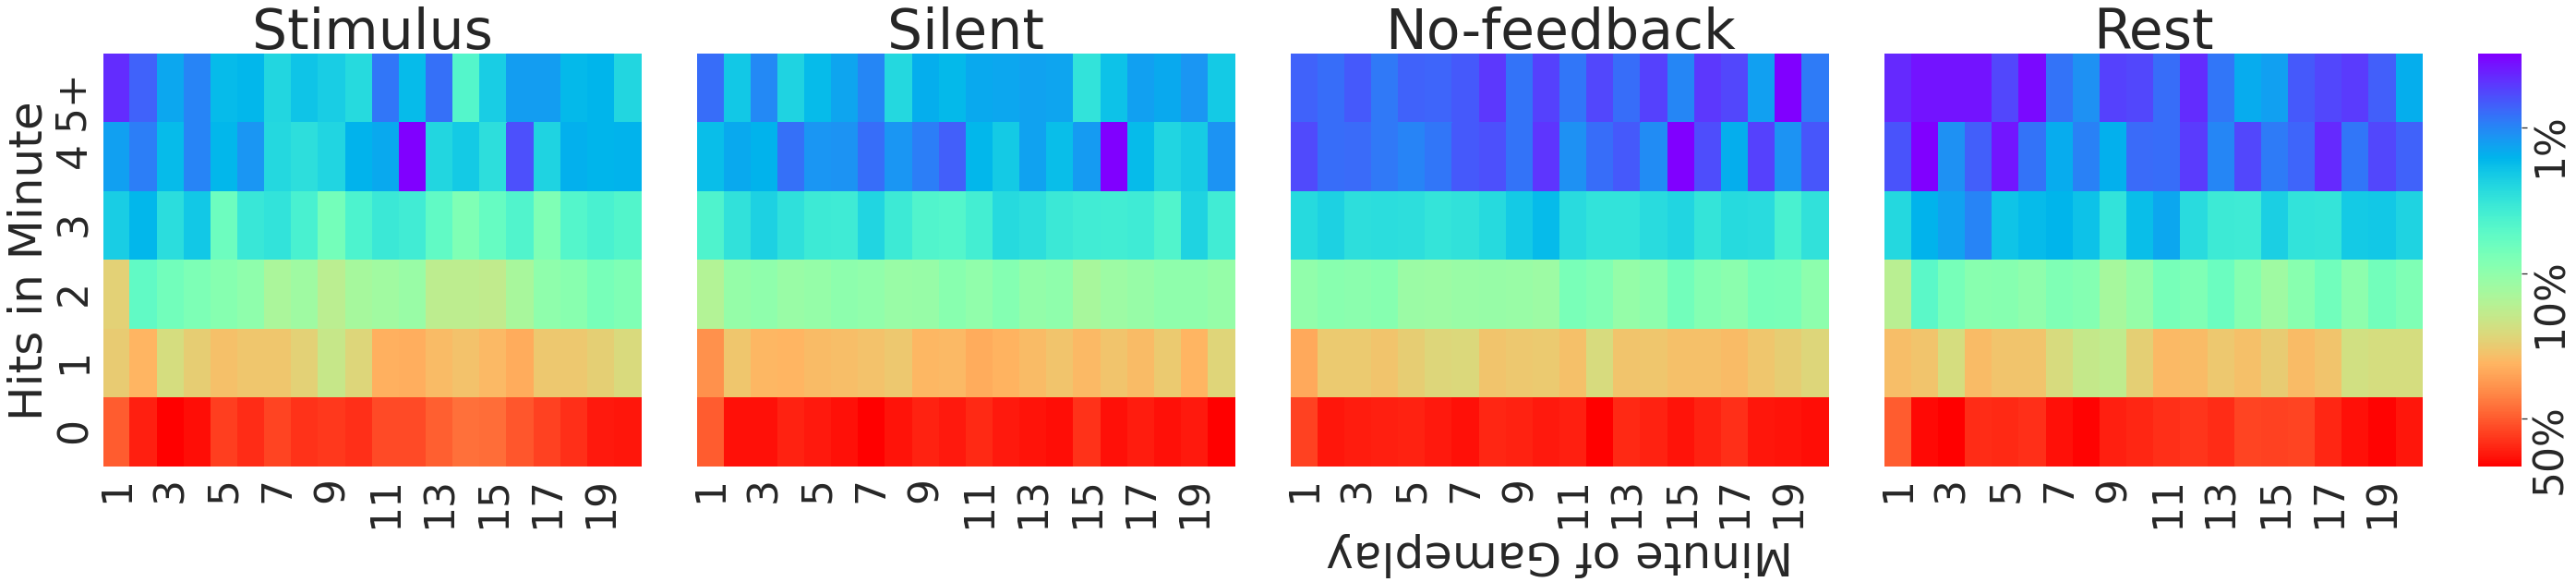

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(font_scale = 4)
fig, (ax1,ax2,ax3,ax4, axcb) = plt.subplots(1, 5, figsize=(40, 10), 
                                                gridspec_kw={'width_ratios':[1,1,1,1,0.08]})

fig.subplots_adjust(wspace=0.05)
sns.heatmap(hcstimhmdf, ax=ax1, cmap='rainbow_r',cbar_ax=axcb)
sns.heatmap(hcsilhmdf, ax=ax2, cmap='rainbow_r', cbar=False, yticklabels=False)
sns.heatmap(hcNFhmdf, ax=ax3, cmap='rainbow_r',cbar=False, yticklabels=False)
sns.heatmap(hcrsthmdf, ax=ax4, cmap='rainbow_r', cbar=False, yticklabels=False)
axcb.set_yticklabels([' ', '50%', '10%', '1%'], rotation = 90)
axcb.yaxis.set_major_locator(plt.MaxNLocator(3))
num = list(range(1,21, 2))
ax1.set_xticklabels(num, rotation=90)

ax2.set_xticklabels(num, rotation=90)
ax3.set_xticklabels(num, rotation=90)
ax4.set_xticklabels(num, rotation=90)
ax1.set_yticklabels(['   5+','4', '3', '2', '1', '0'], rotation = 90)
ax2.set(ylabel=None)
ax3.set(ylabel=None)
ax4.set(ylabel=None)

ax1.set(xlabel=None)
ax2.set(xlabel=None)
ax3.set_xlabel("Minute of Gameplay", size = 50, rotation = 180)
ax1.set_ylabel("Hits in Minute", size = 50)
ax4.set(xlabel=None)

ax4.set_title("Rest", size = 60)
ax1.set_title("Stimulus", size = 60)
ax2.set_title("Silent", size = 60)
ax3.set_title("No-feedback", size = 60)
plt.tight_layout()
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/heatmap_feedback.pdf')
plt.show()

In [63]:
#normalises only by group
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['hit_count']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('hit_count', 1)] = data[('hit_count', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
data["normhc"] = ((data[('hit_count', 0)] - data[('hit_count', 1)]) / data[('hit_count', 1)] ) *100
data = data.reset_index()


data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))
data = data[(data.group != 4)]
data = data[(data.test_day != 3)]

data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 

data['test_day']= np.where((data['test_day'] == 4), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 5), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 6), 2, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 7), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 8), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 9), 2, data['test_day']) 

data[:150]
#data.chip_id.unique()

group                              tag chip_id test_day half  \
control                                                                
0           0            GFP__rate_code_reseed   11597      1.0    0   
1           0            GFP__rate_code_reseed   11597      1.0    0   
2           0            GFP__rate_code_reseed   11597      1.0    0   
3           0            GFP__rate_code_reseed   11597      1.0    1   
4           0            GFP__rate_code_reseed   11597      1.0    1   
5           0            GFP__rate_code_reseed   11597      1.0    1   
6           0            GFP__rate_code_reseed   11597      2.0    0   
7           0            GFP__rate_code_reseed   11597      2.0    0   
8           0            GFP__rate_code_reseed   11597      2.0    0   
9           0            GFP__rate_code_reseed   11597      2.0    1   
10          0            GFP__rate_code_reseed   11597      2.0    1   
11          0            GFP__rate_code_reseed   11597      2.0    1   
12          0            GFP__rate_code_reseed   11609      0.0    0   
13          0            GFP__rate_code_reseed   11609      0.0    0   
14          0            GFP__rate_code_reseed   11609      0.0    0   
15          0            GFP__rate_code_reseed   11609      0.0    1   
16          0            GFP__rate_code_reseed   11609      0.0    1   
17          0            GFP__rate_code_reseed   11609      0.0    1   
18          0            GFP__rate_code_reseed   11609      1.0    0   
19          0            GFP__rate_code_reseed   11609      1.0    0   
20          0            GFP__rate_code_reseed   11609      1.0    0   
21          0            GFP__rate_code_reseed   11609      1.0    1   
22          0            GFP__rate_code_reseed   11609      1.0    1   
23          0            GFP__rate_code_reseed   11609      1.0    1   
24          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
25          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
26          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
27          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
28          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
29          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
30          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
31          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
32          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
33          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
34          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
35          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
36          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
37          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
38          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
39          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
40          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
41          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
42          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
43          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
44          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
45          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
46          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
47          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
48          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
49          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
50          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
51          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
52          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
53          0  GFP_low_test_rate_code_random_3  

In [64]:
len(data)

973

In [65]:
countprim= data.groupby(['chip_id']).mean()
countprim

group  test_day      half session_num hit_count            \
control                                                   0         1   
chip_id                                                                 
11570    1.000000  1.000000  0.500000    4.000000  0.782741  0.963648   
11597    1.000000  1.038462  0.500000    4.115385  0.823040  0.736588   
11609    1.000000  1.000000  0.500000    4.000000  0.887441  0.815401   
11610    1.000000  1.000000  0.500000    4.000000  0.853612  0.739789   
11613    1.000000  1.000000  0.500000    4.000000  0.921506  0.844941   
11614    0.000000  1.000000  0.500000    4.000000  0.862862  0.773955   
11615    0.600000  0.800000  0.500000    3.600000  1.023111  0.764571   
11618    1.000000  1.000000  0.500000    4.000000  0.765869  0.831010   
11619    0.000000  1.000000  0.500000    4.000000  0.904938  0.612632   
11621    0.000000  1.000000  0.500000    4.000000  0.879321  0.603505   
11623    0.545455  0.454545  0.500000    2.909091  0.960860  0.818745   
12106    1.219512  0.853659  0.487805    3.707317  1.141085  0.767322   
12123    1.000000  1.000000  0.500000    4.000000  0.883572  0.777721   
12138    1.000000  1.000000  0.500000    4.000000  1.172581  0.903237   
12160    0.000000  0.000000  0.500000    2.000000  0.782222  0.627183   
12250    1.000000  0.875000  0.500000    3.750000  1.032971  0.842767   
12265    1.000000  1.000000  0.500000    4.000000  0.855508  0.874376   
12285    1.000000  1.000000  0.500000    4.000000  1.071940  0.837115   
13113    2.000000  0.500000  0.500000    3.000000  0.816938  0.793980   
13117    2.000000  0.000000  0.500000    2.000000  0.953452  0.741374   
13168    2.000000  0.500000  0.500000    3.000000  0.978313  0.792870   
9353     0.166667  0.666667  0.500000    3.000000  0.804136  0.720741   
9358     0.200000  0.800000  0.500000    2.800000  0.844204  0.749702   
9381     0.000000  1.000000  0.500000    4.000000  0.781995  0.668902   
9468     0.500000  0.500000  0.500000    3.000000  0.965810  0.731895   
9495     0.272727  0.909091  0.500000    3.090909  0.850589  0.731064   
9501     0.000000  1.000000  0.500000    4.000000  0.897798  0.593677   

            normhc  
control             
chip_id             
11570    -8.373160  
11597    16.293806  
11609    11.636394  
11610    18.713900  
11613    10.305513  
11614    15.604958  
11615    36.699598  
11618    -6.461187  
11619    52.705647  
11621    47.745336  
11623    22.471035  
12106    64.348119  
12123    15.224125  
12138    31.768770  
12160    24.720025  
12250    35.750697  
12265     1.553236  
12285    32.184489  
13113     3.206383  
13117    28.606191  
13168    27.085288  
9353     12.184801  
9358     17.362459  
9381     26.306939  
9468     31.290769  
9495     19.909305  
9501     66.242776

In [66]:
aov = pg.mixed_anova(data=data, dv=('normhc'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
group        28245.063      2    165  14122.531  4.576    0.012  0.053  nan
half         14603.331      1    165  14603.331  8.685    0.004  0.050    1.000
Interaction  20768.205      2    165  10384.103  6.175    0.003  0.070  nan



In [67]:
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 

Half0 = data[(data.half == 0)] 
Half1 = data[(data.half == 1)] 

Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [68]:
aov = pg.anova(data=Half0, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF        MS        F    p-unc      np2
--------  -----------  ----  --------  -------  -------  -------
group       15118.754     2  7559.377    2.181    0.114    0.009
Within    1677238.577   484  3465.369  nan      nan      nan



In [69]:
aov = pg.anova(data=Half1, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF         MS        F    p-unc      np2
--------  -----------  ----  ---------  -------  -------  -------
group      107887.859     2  53943.929   20.507    0.000    0.078
Within    1270526.294   483   2630.489  nan      nan      nan



In [70]:
pg.pairwise_gameshowell(data =Half1, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   43.351   21.394  21.957  6.006  3.656  309.729  0.001   0.396
1  0  2   43.351    8.175  35.175  4.604  7.640  339.144  0.001   0.854
2  1  2   21.394    8.175  13.219  5.091  2.596  198.782  0.027   0.324

In [71]:
pg.pairwise_gameshowell(data =data, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   26.470   21.751   4.719  4.687  1.007  587.819  0.568   0.077
1  0  2   26.470    8.875  17.596  3.664  4.802  702.976  0.001   0.380
2  1  2   21.751    8.875  12.876  4.231  3.043  430.201  0.007   0.269

In [72]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normhc'], Stimulus1['normhc'])

Ttest_relResult(statistic=-7.479502683466953, pvalue=1.5814285717151388e-12)

In [73]:
countprim= Stimulus0.groupby(['group', 'chip_id']).mean()
countprim

test_day half session_num hit_count                normhc
control                                         0         1            
group chip_id                                                          
0     11570      1.000    0        4.00  0.657037  0.872870  -22.305148
      11597      1.000    0        4.00  0.639583  0.805124  -19.475097
      11609      1.000    0        4.00  0.819769  0.727513   13.127061
      11610      1.000    0        4.00  0.735926  0.723624    3.401140
      11613      1.000    0        4.00  0.609259  0.688651  -10.814677
      11614      1.000    0        4.00  0.645556  0.773955  -14.047335
      11615      0.500    0        3.00  0.732778  0.658690   10.901245
      11618      1.000    0        4.00  0.662963  0.755992  -11.296027
      11619      1.000    0        4.00  0.703704  0.612632   18.867913
      11621      1.000    0        4.00  0.684815  0.603505   11.664062
      11623      0.400    0        2.80  1.062762  0.962333   10.500268
      12106      0.250    0        2.50  1.483333  0.462897  220.445778
      12123      1.000    0        4.00  1.118889  0.725926   50.871296
      12138      1.000    0        4.00  1.222037  0.881778   37.980738
      12160      0.000    0        2.00  0.631111  0.627183    0.626384
      12250      1.000    0        4.00  0.826296  0.847659   20.507496
      12265      1.000    0        4.00  0.697536  0.897315  -17.828460
      12285      1.000    0        4.00  0.957407  0.793218   20.079114
      9353       0.800    0        3.20  0.648222  0.705603   -7.090119
      9358       0.875    0        2.75  0.645556  0.733403   -8.509892
      9381       1.000    0        4.00  0.746296  0.668902   23.425836
      9468       0.500    0        3.00  0.905417  0.708730   20.795473
      9495       0.875    0        2.75  0.722361  0.686085    6.901979
      9501       1.000    0        4.00  0.760000  0.593677   39.979405

In [74]:
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Stimulus0 = Stimulus0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
stats.ttest_rel(Silent0['normhc'], Silent1['normhc'])


Ttest_relResult(statistic=0.11386060188056854, pvalue=0.9095199954757324)

In [75]:
countprim= Silent0.groupby(['group', 'chip_id']).mean()
countprim

test_day half session_num hit_count               normhc
control                                         0         1           
group chip_id                                                         
1     11570      1.000    0       4.000  0.915185  0.871918  23.620077
      11597      1.125    0       4.375  0.915565  0.657004  40.006027
      11609      1.000    0       4.000  0.842593  0.951759  -9.574366
      11613      1.000    0       4.000  0.894815  0.920238  -0.054265
      11615      1.000    0       4.000  1.089259  0.835159  34.233414
      11618      1.000    0       4.000  0.895926  0.861865   5.442937
      11623      0.500    0       3.000  0.753333  0.699087   8.493642
      12106      1.000    0       4.000  1.263280  0.836423  56.582074
      12123      1.000    0       4.000  0.772619  0.827232  -5.892966
      12138      1.000    0       4.000  1.598975  0.990577  67.695736
      12250      0.500    0       3.000  0.764444  0.812679  -2.254526
      12265      1.000    0       4.000  0.886340  0.842447   3.964049
      12285      1.000    0       4.000  1.200979  0.946727  37.280364
      9353       0.000    0       2.000  1.177778  0.796429  47.882412
      9358       0.500    0       3.000  0.891667  0.814901  17.069140
      9468       0.500    0       3.000  1.228194  0.755060  63.296935
      9495       1.000    0       4.000  0.903333  0.851005   6.617566

In [76]:
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Stimulus0 = Stimulus0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
stats.ttest_rel(Open0['normhc'], Open1['normhc'])


Ttest_relResult(statistic=0.4373862789513026, pvalue=0.6626109039986738)

In [77]:
countprim= Open0.groupby(['group', 'tag', 'chip_id']).mean()
countprim

test_day half session_num hit_count  \
control                                                             0   
group tag                 chip_id                                       
2     gfp_test_open_loop  11570        1.0    0         4.0  0.758316   
                          11609        1.0    0         4.0  0.887725   
      ngn2_test_open_loop 12106        1.0    0         4.0  0.823785   
                          12123        1.0    0         4.0  0.720635   
                          12138        1.0    0         4.0  0.794259   
                          12250        1.0    0         4.0  0.943739   
                          12265        1.0    0         4.0  1.052557   
                          12285        1.0    0         4.0  1.209982   
      prim_test_open_loop 11597        1.0    0         4.0  0.892972   
                          11610        1.0    0         4.0  0.858333   
                          11613        1.0    0         4.0  0.987028   
                          11618        1.0    0         4.0  0.792769   
                          13113        0.5    0         3.0  0.816508   
                          13117        0.0    0         2.0  0.874577   
                          13168        0.5    0         3.0  0.979537   

                                                normhc  
control                                   1             
group tag                 chip_id                       
2     gfp_test_open_loop  11570    1.146157 -33.547991  
                          11609    0.766931  16.806657  
      ngn2_test_open_loop 12106    0.822769   0.338793  
                          12123    0.780005  -7.294299  
                          12138    0.837356  -3.227240  
                          12250    0.857935  11.091841  
                          12265    0.883366  22.896346  
                          12285    0.771400  55.149785  
      prim_test_open_loop 11597    0.717620  28.570007  
                          11610    0.755955  13.281643  
                          11613    0.925935   6.770823  
                          11618    0.875173  -7.567970  
                          13113    0.793980   2.639098  
                          13117    0.741374  17.967067  
                          13168    0.792870  28.211194

In [78]:
aov = pg.mixed_anova(data=Half1, dv=('normhc'), subject=('id'), between='group', 
                     within= 'test_day',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ---------  -----  -----  ---------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
group        98629.255      2    164  49314.628  7.674    0.001      nan      0.086  nan           nan        nan        nan
test_day        32.230      2    328     16.115  0.037    0.963        0.963  0.000    0.995         1.000      0.995      0.739
Interaction   3633.791      4    328    908.448  2.100    0.081      nan      0.025  nan           nan        nan        nan



In [79]:
pg.pairwise_gameshowell(data =Half1, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   43.351   21.394  21.957  6.006  3.656  309.729  0.001   0.396
1  0  2   43.351    8.175  35.175  4.604  7.640  339.144  0.001   0.854
2  1  2   21.394    8.175  13.219  5.091  2.596  198.782  0.027   0.324

In [80]:
Stimulus = Half1[(data.group == 0)]  
Silent = Half1[(data.group == 1)] 
Open = Half1[(data.group == 2)] 
Day0 = Half1[(data.test_day == 0)]  
Day1 = Half1[(data.test_day == 1)]  
Day2 = Half1[(data.test_day == 2)] 

In [81]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Stimulus, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      ng2      eps
--------  ----------  ----  --------  -------  -------  -------  -------
test_day    1823.268     2   911.634   -3.704    1.000    0.002    0.989
Error     -34951.605   142  -246.138  nan      nan      nan      nan



In [82]:
pg.pairwise_gameshowell(data =Stimulus, dv='normhc', between='test_day').round(3)

A    B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0.0  1.0   45.647   44.381  1.265  9.751  0.130  163.407  0.900   0.020
1  0.0  2.0   45.647   38.871  6.776  9.410  0.720  144.708  0.733   0.119
2  1.0  2.0   44.381   38.871  5.510  9.690  0.569  140.628  0.819   0.095

In [83]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Silent, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      ng2      eps
--------  ----------  ----  --------  -------  -------  -------  -------
test_day    1465.794     2   732.897    0.372    0.690    0.004    0.935
Error     193169.170    98  1971.114  nan      nan      nan      nan



In [84]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Open, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      ng2      eps
--------  ---------  ----  -------  -------  -------  -------  -------
test_day    376.958     2  188.479    0.943    0.393    0.005    0.979
Error     17590.768    88  199.895  nan      nan      nan      nan



In [85]:
pg.pairwise_gameshowell(data =Half1, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   43.351   21.394  21.957  6.006  3.656  309.729  0.001   0.396
1  0  2   43.351    8.175  35.175  4.604  7.640  339.144  0.001   0.854
2  1  2   21.394    8.175  13.219  5.091  2.596  198.782  0.027   0.324

In [86]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Stimulus, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      ng2      eps
--------  ----------  ----  --------  -------  -------  -------  -------
test_day    1823.268     2   911.634   -3.704    1.000    0.002    0.989
Error     -34951.605   142  -246.138  nan      nan      nan      nan



In [87]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Silent, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      ng2      eps
--------  ----------  ----  --------  -------  -------  -------  -------
test_day    1465.794     2   732.897    0.372    0.690    0.004    0.935
Error     193169.170    98  1971.114  nan      nan      nan      nan



In [88]:
aov = pg.rm_anova(dv='normhc', within='test_day',
                  subject='id', data=Open, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      ng2      eps
--------  ---------  ----  -------  -------  -------  -------  -------
test_day    376.958     2  188.479    0.943    0.393    0.005    0.979
Error     17590.768    88  199.895  nan      nan      nan      nan



In [89]:
aov = pg.anova(data=Day0, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF         MS        F    p-unc      np2
--------  ----------  ----  ---------  -------  -------  -------
group      51038.042     2  25519.021    8.663    0.000    0.088
Within    527290.410   179   2945.756  nan      nan      nan



In [90]:
aov = pg.anova(data=Day1, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF         MS        F    p-unc      np2
--------  ----------  ----  ---------  -------  -------  -------
group      41566.621     2  20783.311    7.651    0.001    0.084
Within    450919.816   166   2716.384  nan      nan      nan



In [91]:
aov = pg.anova(data=Day2, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      np2
--------  ----------  ----  --------  -------  -------  -------
group      18708.182     2  9354.091    4.277    0.016    0.061
Within    288665.404   132  2186.859  nan      nan      nan



In [92]:
pg.pairwise_gameshowell(data =Day0, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff      se      T       df   pval  hedges
0  0  1   45.647   17.127  28.520  10.384  2.747  111.470  0.019   0.485
1  0  2   45.647    7.956  37.690   7.983  4.721  128.959  0.001   0.862
2  1  2   17.127    7.956   9.171   9.045  1.014   75.236  0.566   0.207

In [93]:
pg.pairwise_gameshowell(data =Day1, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   44.381   23.583  20.798  9.928  2.095  118.966  0.095   0.380
1  0  2   44.381    6.239  38.142  8.071  4.726  113.187  0.001   0.902
2  1  2   23.583    6.239  17.344  7.955  2.180   72.380  0.082   0.460

In [94]:
pg.pairwise_gameshowell(data =Day2, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff      se      T      df   pval  hedges
0  0  1   38.871   24.400  14.471  11.045  1.310  72.255  0.396   0.272
1  0  2   38.871   10.654  28.217   7.685  3.672  92.923  0.001   0.761
2  1  2   24.400   10.654  13.747   9.678  1.420  48.230  0.339   0.331

In [95]:
data.columns

MultiIndex([(      'group', ''),
            (        'tag', ''),
            (    'chip_id', ''),
            (   'test_day', ''),
            (       'half', ''),
            ('session_num', ''),
            (  'hit_count',  0),
            (  'hit_count',  1),
            (     'normhc', ''),
            (         'id', '')],
           names=[None, 'control'])

In [96]:
d = {'group': data[(      'group', '')], 'score': data[(     'normhc', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

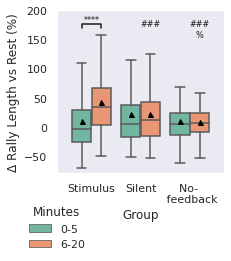

In [97]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Stimulus", "Silent", "No- \n feedback"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Δ Rally Length vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 170, 5.6, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)
#Plot differences between groups time 2
plt.text(x11, y, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(x21, y, "###", ha='center', va='bottom', color=col, fontsize=8)
plt.text(x21, y-20, "%", ha='center', va='bottom', color=col, fontsize=8)


# Plot extra legend
#plt.text(4.4, 1.38, "#=p<0.01 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, 1.15, "#=p<0.05 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, .92, "%%=p<0.01  \n vs Silent", ha='center', va='bottom', color=col)
#plt.text(4.4, .69, "%=p<0.05  \n vs Silent", ha='center', va='bottom', color=col)

ax.set_ylim([-80, 200])
sns.set(rc={'figure.figsize':(3,3)})

#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_normhc_sig.pdf', bbox_inches='tight')  


Text(2.2, 9, '###')

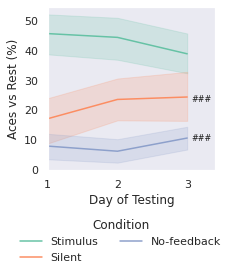

In [104]:
labels = data.test_day.unique()
x_pos = np.arange(len(labels))
x = Half1['test_day']
y = Half1['normhc']
hue = Half1['group']
sns.set(style="darkgrid")
ax = sns.lineplot(data=data, x=x, y=y, hue=hue, palette="Set2", err_style = "band", ci= 68)
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.6), title = "Condition", borderaxespad=0.1, frameon=False, ncol = 2)
L.get_texts()[0].set_text('Stimulus')
L.get_texts()[1].set_text('Silent')
L.get_texts()[2].set_text('No-feedback')
ax.grid(False)
ax.set_xticks(x_pos)
ax.set_xticklabels(("1", "2", "3"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Aces vs Rest (%)')
ax.set_xlabel('Day of Testing')
#ax.set_ylim([0.6, 1])
ax.set_xlim([0, 2.4])

plt.text(2.2, 22, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(2.2, 9, "###", ha='center', va='bottom', color=col, fontsize=8)


#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_normhc_days_sig.pdf', bbox_inches='tight')  


In [105]:
#normalises only by group for aces
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['ace']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('ace', 1)] = data[('ace', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
data["normace"] = (data[('ace', 0)] - data[('ace', 1)]) *100#/ data[('ace', 1)] ) *100
data = data.reset_index()
data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))

data['test_day']= np.where((data['test_day'] == 4), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 5), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 6), 2, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 7), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 8), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 9), 2, data['test_day']) 
data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 
data = data[(data.group != 4)]
data = data[(data.test_day != 3)]

data[:150]
#data.chip_id.unique()

group                              tag chip_id test_day half  \
control                                                                
0           0            GFP__rate_code_reseed   11597      1.0    0   
1           0            GFP__rate_code_reseed   11597      1.0    0   
2           0            GFP__rate_code_reseed   11597      1.0    0   
3           0            GFP__rate_code_reseed   11597      1.0    1   
4           0            GFP__rate_code_reseed   11597      1.0    1   
5           0            GFP__rate_code_reseed   11597      1.0    1   
6           0            GFP__rate_code_reseed   11597      2.0    0   
7           0            GFP__rate_code_reseed   11597      2.0    0   
8           0            GFP__rate_code_reseed   11597      2.0    0   
9           0            GFP__rate_code_reseed   11597      2.0    1   
10          0            GFP__rate_code_reseed   11597      2.0    1   
11          0            GFP__rate_code_reseed   11597      2.0    1   
12          0            GFP__rate_code_reseed   11609      0.0    0   
13          0            GFP__rate_code_reseed   11609      0.0    0   
14          0            GFP__rate_code_reseed   11609      0.0    0   
15          0            GFP__rate_code_reseed   11609      0.0    1   
16          0            GFP__rate_code_reseed   11609      0.0    1   
17          0            GFP__rate_code_reseed   11609      0.0    1   
18          0            GFP__rate_code_reseed   11609      1.0    0   
19          0            GFP__rate_code_reseed   11609      1.0    0   
20          0            GFP__rate_code_reseed   11609      1.0    0   
21          0            GFP__rate_code_reseed   11609      1.0    1   
22          0            GFP__rate_code_reseed   11609      1.0    1   
23          0            GFP__rate_code_reseed   11609      1.0    1   
24          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
25          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
26          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
27          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
28          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
29          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
30          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
31          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
32          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
33          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
34          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
35          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
36          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
37          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
38          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
39          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
40          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
41          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
42          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
43          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
44          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
45          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
46          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
47          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
48          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
49          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
50          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
51          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
52          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
53          0  GFP_low_test_rate_code_random_3  

In [106]:
aov = pg.mixed_anova(data=data, dv=('normace'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  --------  -----  -----  -------  -----  -------  -----  -------
group        1972.221      2    165  986.111  7.931    0.001  0.088  nan
half            9.920      1    165    9.920  0.272    0.602  0.002    1.000
Interaction   672.665      2    165  336.333  9.237    0.000  0.101  nan



In [107]:
Half0 = data[(data.half == 0)]
Half1 = data[(data.half == 1)]
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 


Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [108]:
aov = pg.anova(data=Half0, dv=('normace'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF       MS        F    p-unc      np2
--------  ----------  ----  -------  -------  -------  -------
group        906.929     2  453.464    2.072    0.127    0.008
Within    105932.451   484  218.869  nan      nan      nan



In [109]:
pg.pairwise_gameshowell(data =Half0, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -5.633   -4.809 -0.824  1.502 -0.548  267.191  0.831  -0.059
1  0  2   -5.633   -2.283 -3.350  1.835 -1.826  195.485  0.164  -0.204
2  1  2   -4.809   -2.283 -2.526  2.016 -1.253  230.340  0.425  -0.156

In [110]:
aov = pg.anova(data=Half1, dv=('normace'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF        MS        F    p-unc      np2
--------  ---------  ----  --------  -------  -------  -------
group      5813.227     2  2906.613   18.096    0.000    0.070
Within    77582.312   483   160.626  nan      nan      nan



In [111]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normace'], Stimulus1['normace'])

Ttest_relResult(statistic=3.2118177362765583, pvalue=0.0015084625516552234)

In [112]:

Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normace'], Stimulus1['normace'])
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
stats.ttest_rel(Silent0['normace'], Silent1['normace'])


Ttest_relResult(statistic=-2.305246513877045, pvalue=0.022700850843330865)

In [113]:
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
stats.ttest_rel(Open0['normace'], Open1['normace'])

Ttest_relResult(statistic=-0.7932111460791383, pvalue=0.42920747004412807)

In [114]:
pg.pairwise_gameshowell(data =Half1, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -8.669   -1.871 -6.798  1.173 -5.795  288.862  0.001  -0.628
1  0  2   -8.669   -1.606 -7.063  1.692 -4.174  178.239  0.001  -0.466
2  1  2   -1.871   -1.606 -0.265  1.779 -0.149  200.322  0.900  -0.019

In [115]:
aov = pg.mixed_anova(data=Half1, dv=('normace'), subject=('id'), between='group', 
                     within= ('test_day'),
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  --------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
group        5366.505      2    164  2683.252  12.125    0.000      nan      0.129  nan           nan        nan        nan
test_day      221.091      2    328   110.546   0.971    0.380        0.382  0.006    0.998         1.000      0.998      0.881
Interaction   721.836      4    328   180.459   1.585    0.178      nan      0.019  nan           nan        nan        nan



In [116]:
pg.pairwise_gameshowell(data =Half1, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -8.669   -1.871 -6.798  1.173 -5.795  288.862  0.001  -0.628
1  0  2   -8.669   -1.606 -7.063  1.692 -4.174  178.239  0.001  -0.466
2  1  2   -1.871   -1.606 -0.265  1.779 -0.149  200.322  0.900  -0.019

In [117]:
d = {'group': data[(      'group', '')], 'score': data[(     'normace', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

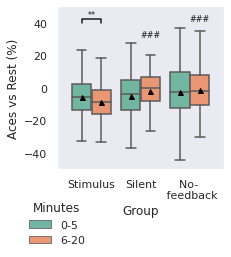

In [118]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Stimulus", "Silent", "No- \n feedback"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Aces vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 40, 2, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "**", ha='center', va='bottom', color=col, fontsize=8)

#Plot differences between groups time 2
plt.text(x11, y-10, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(x21, y, "###", ha='center', va='bottom', color=col, fontsize=8)



# Plot extra legend
#plt.text(4.4, 1.38, "#=p<0.01 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, 1.15, "#=p<0.05 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, .92, "%%=p<0.01  \n vs Silent", ha='center', va='bottom', color=col)
#plt.text(4.4, .69, "%=p<0.05  \n vs Silent", ha='center', va='bottom', color=col)

ax.set_ylim([-50, 50])
sns.set(rc={'figure.figsize':(3,3)})

#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_ace_sig.pdf', bbox_inches='tight')

Text(2.2, -3.2, '###')

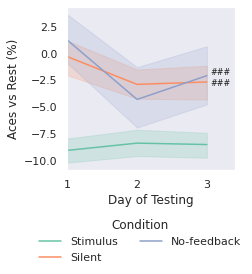

In [119]:
labels = data.test_day.unique()
x_pos = np.arange(len(labels))
x = Half1['test_day']
y = Half1['normace']
hue = Half1['group']
sns.set(style="darkgrid")
ax = sns.lineplot(data=data, x=x, y=y, hue=hue, palette="Set2", err_style = "band", ci= 68)
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.6), title = "Condition", borderaxespad=0.1, frameon=False, ncol = 2)
L.get_texts()[0].set_text('Stimulus')
L.get_texts()[1].set_text('Silent')
L.get_texts()[2].set_text('No-feedback')
ax.grid(False)
ax.set_xticks(x_pos)
ax.set_xticklabels(("1", "2", "3"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Aces vs Rest (%)')
ax.set_xlabel('Day of Testing')
#ax.set_ylim([0.6, 1])
ax.set_xlim([0, 2.4])

plt.text(2.2, -2.2, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(2.2, -3.2, "###", ha='center', va='bottom', color=col, fontsize=8)


#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_ace_days_sig.pdf', bbox_inches='tight')  


In [120]:
#normalises only by group for long_rally
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['long_rally']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('long_rally', 1)] = data[('long_rally', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
#data['long_rally', 0]= np.where((data['long_rally', 0] == 0.000000), 0.000001, data['long_rally', 0]) 
#data['long_rally', 1]= np.where((data['long_rally', 1] == 0.000000), 0.000001, data['long_rally', 1]) 
data["normlr"] = (data[('long_rally', 0)] - data[('long_rally', 1)]) * 100 # / data[('long_rally', 1)] ) *100
data = data.dropna()
data = data.reset_index()

data['test_day']= np.where((data['test_day'] == 4), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 5), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 6), 2, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 7), 0, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 8), 1, data['test_day']) 
data['test_day']= np.where((data['test_day'] == 9), 2, data['test_day']) 
data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 


data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))
data = data[(data.group != 4)]
data = data[(data.test_day != 3)]


data[200:400]
#data.chip_id.unique()

group                                  tag chip_id test_day half  \
control                                                                    
218         0                 GFP_rate_code-reseed   11610      0.0    0   
219         0                 GFP_rate_code-reseed   11610      0.0    1   
220         0                 GFP_rate_code-reseed   11610      0.0    1   
221         0                 GFP_rate_code-reseed   11610      0.0    1   
222         0                 GFP_rate_code-reseed   11610      1.0    0   
223         0                 GFP_rate_code-reseed   11610      1.0    0   
224         0                 GFP_rate_code-reseed   11610      1.0    0   
225         0                 GFP_rate_code-reseed   11610      1.0    1   
226         0                 GFP_rate_code-reseed   11610      1.0    1   
227         0                 GFP_rate_code-reseed   11610      1.0    1   
228         0                 GFP_rate_code-reseed   11610      2.0    0   
229         0                 GFP_rate_code-reseed   11610      2.0    0   
230         0                 GFP_rate_code-reseed   11610      2.0    0   
231         0                 GFP_rate_code-reseed   11610      2.0    1   
232         0                 GFP_rate_code-reseed   11610      2.0    1   
233         0                 GFP_rate_code-reseed   11610      2.0    1   
234         0                 GFP_rate_code-reseed   11613      1.0    0   
235         0                 GFP_rate_code-reseed   11613      1.0    0   
236         0                 GFP_rate_code-reseed   11613      1.0    0   
237         0                 GFP_rate_code-reseed   11613      1.0    1   
238         0                 GFP_rate_code-reseed   11613      1.0    1   
239         0                 GFP_rate_code-reseed   11613      1.0    1   
240         0                 GFP_rate_code-reseed   11613      2.0    0   
241         0                 GFP_rate_code-reseed   11613      2.0    0   
242         0                 GFP_rate_code-reseed   11613      2.0    0   
243         0                 GFP_rate_code-reseed   11613      2.0    1   
244         0                 GFP_rate_code-reseed   11613      2.0    1   
245         0                 GFP_rate_code-reseed   11613      2.0    1   
252         0                 GFP_rate_code_reseed   11570      0.0    0   
253         0                 GFP_rate_code_reseed   11570      0.0    0   
254         0                 GFP_rate_code_reseed   11570      0.0    0   
255         0                 GFP_rate_code_reseed   11570      0.0    1   
256         0                 GFP_rate_code_reseed   11570      0.0    1   
257         0                 GFP_rate_code_reseed   11570      0.0    1   
258         0                 GFP_rate_code_reseed   11570      1.0    0   
259         0                 GFP_rate_code_reseed   11570      1.0    0   
260         0                 GFP_rate_code_reseed   11570      1.0    0   
261         0                 GFP_rate_code_reseed   11570      1.0    1   
262         0                 GFP_rate_code_reseed   11570      1.0    1   
263         0                 GFP_rate_code_reseed   11570      1.0    1   
264         0                 GFP_rate_code_reseed   11570      2.0    0   
265         0                 GFP_rate_code_reseed   11570      2.0    0   
266         0                 GFP_rate_code_reseed   11570      2.0    0   
267         0                 GFP_rate_code_reseed   11570      2.0    1   
268         0                 GFP_rate_code_reseed   11570      2.0    1   
269         0                 GFP_rate_code_reseed   11570      2.0    1   
276         0                 GFP_rate_code_reseed   11609      2.0    0   
277         0                 GFP_rate_code_reseed   11609      2.0    0   
278         0                 GFP_rate_code_reseed   11609      2.0    0   
279         0                 GFP_rate_code_reseed   11609      2.0    1   
280         0                 GFP_rate_code_reseed   116

In [121]:
aov = pg.mixed_anova(data=data, dv=('normlr'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    np2      eps
-----------  --------  -----  -----  --------  ------  -------  -----  -------
group         104.015      2    353    52.007   0.650    0.523  0.004  nan
half         1089.865      1    353  1089.865  29.932    0.000  0.078    1.000
Interaction   873.872      2    353   436.936  12.000    0.000  0.064  nan



In [122]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
print(stats.ttest_rel(Stimulus0['normlr'], Stimulus1['normlr']))
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
print(stats.ttest_rel(Silent0['normlr'], Silent1['normlr']))
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
print(stats.ttest_rel(Open0['normlr'], Open1['normlr']))

Ttest_relResult(statistic=-8.541357927873502, pvalue=1.8710653861371673e-15)
Ttest_relResult(statistic=-0.44379441978192435, pvalue=0.657912388650317)
Ttest_relResult(statistic=-0.9174879495261817, pvalue=0.3607121497140996)


In [123]:
Half0 = data[(data.half == 0)]
Half1 = data[(data.half == 1)]
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 


Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [124]:
aov = pg.anova(data=Half0, dv=('normlr'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      np2
--------  ---------  ----  -------  -------  -------  -------
group      1235.415     2  617.708    8.513    0.000    0.034
Within    35120.571   484   72.563  nan      nan      nan



In [125]:
pg.pairwise_gameshowell(data =Half0, dv='normlr', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -1.689    1.800 -3.489  0.959 -3.640  234.350  0.001  -0.394
1  0  2   -1.689    1.082 -2.771  0.957 -2.896  215.082  0.012  -0.323
2  1  2    1.800    1.082  0.717  1.152  0.623  253.482  0.788   0.078

In [126]:
aov = pg.anova(data=Half1, dv=('normlr'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      np2
--------  ---------  ----  -------  -------  -------  -------
group       325.868     2  162.934    3.219    0.041    0.013
Within    24448.970   483   50.619  nan      nan      nan



In [127]:
pg.pairwise_gameshowell(data =Half1, dv='normlr', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1    3.480    2.195  1.285  0.794  1.619  250.019  0.240   0.176
1  0  2    3.480    1.580  1.900  0.794  2.393  229.450  0.046   0.267
2  1  2    2.195    1.580  0.615  0.933  0.659  253.410  0.767   0.082

In [128]:
aov = pg.mixed_anova(data=Half1, dv=('normlr'), subject=('id'), between='group', 
                     within= 'test_day',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    p-GG-corr     np2      eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  -------  ------  -------  -----------  ------  -------  ------------  ---------  ---------
group        308.891      2    164  154.446   0.490    0.614      nan       0.006  nan           nan        nan        nan
test_day      43.356      2    328   21.678  -0.244    1.000        1.000  -0.001    0.988         1.000      0.988      0.779
Interaction  475.117      4    328  118.779  -1.336    1.000      nan      -0.017  nan           nan        nan        nan



In [129]:
Stimulus = Half1[(Half1.group == 0)]  
Silent = Half1[(Half1.group == 1)] 
Open = Half1[(Half1.group == 2)] 

In [130]:
aov = pg.rm_anova(dv='normlr', within='test_day',
                  subject='id', data=Stimulus, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF       MS        F    p-unc      ng2      eps
--------  ----------  ----  -------  -------  -------  -------  -------
test_day      51.796     2   25.898   -0.314    1.000    0.006    0.990
Error     -11727.669   142  -82.589  nan      nan      nan      nan



In [131]:
aov = pg.rm_anova(dv='normlr', within='test_day',
                  subject='id', data=Silent, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF        MS        F    p-unc      ng2      eps
--------  ----------  ----  --------  -------  -------  -------  -------
test_day     245.577     2   122.788   -1.187    1.000    0.032    0.851
Error     -10134.361    98  -103.412  nan      nan      nan      nan



In [132]:
aov = pg.rm_anova(dv='normlr', within='test_day',
                  subject='id', data=Open, detailed=True,
                  effsize="ng2")
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      ng2      eps
--------  ---------  ----  -------  -------  -------  -------  -------
test_day    221.101     2  110.551   -1.385    1.000    0.034    0.849
Error     -7023.974    88  -79.818  nan      nan      nan      nan



In [133]:
d = {'group': data[(      'group', '')], 'score': data[(     'normlr', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

In [134]:
ad

group      score         id  test_day  session_num  half  stim  sil  nf
0         0 -14.773810  0115974.0       1.0          4.0     0     1    0   0
1         0  -8.107143  0115975.0       1.0          5.0     0     1    0   0
2         0  -8.107143  0115973.0       1.0          3.0     0     1    0   0
3         0  -8.662698  0115974.0       1.0          4.0     1     1    0   0
4         0 -10.329365  0115975.0       1.0          5.0     1     1    0   0
...     ...        ...        ...       ...          ...   ...   ...  ...  ..
1004      2   2.333333  2131685.0       1.0          5.0     0     0    0   1
1005      2   1.666667  2131683.0       1.0          3.0     0     0    0   1
1006      2  -0.428571  2131684.0       1.0          4.0     1     0    0   1
1007      2  -2.373016  2131685.0       1.0          5.0     1     0    0   1
1008      2   7.888889  2131683.0       1.0          3.0     1     0    0   1

[973 rows x 9 columns]

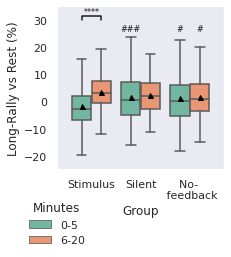

In [135]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Stimulus", "Silent", "No- \n feedback"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Long-Rally vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 30, 1.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)

#Plot differences between groups time 2
plt.text(x10, y-5, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(x20, y-5, "#", ha='center', va='bottom', color=col, fontsize=8)



plt.text(x21, y-5, "#", ha='center', va='bottom', color=col, fontsize=8)


# Plot extra legend
#plt.text(4.4, 1.38, "#=p<0.01 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, 1.15, "#=p<0.05 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, .92, "%%=p<0.01  \n vs Silent", ha='center', va='bottom', color=col)
#plt.text(4.4, .69, "%=p<0.05  \n vs Silent", ha='center', va='bottom', color=col)

ax.set_ylim([-25, 35])
sns.set(rc={'figure.figsize':(3,3)})

#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_lr_sig.pdf', bbox_inches='tight')

(0.0, 2.4)

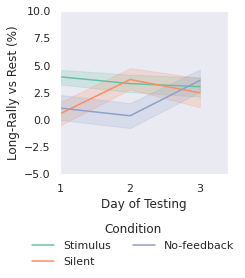

In [136]:
labels = data.test_day.unique()
x_pos = np.arange(len(labels))
x = Half1['test_day']
y = Half1['normlr']
hue = Half1['group']
sns.set(style="darkgrid")
ax = sns.lineplot(data=data, x=x, y=y, hue=hue, palette="Set2", err_style = "band", ci= 68)
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.6), title = "Condition", borderaxespad=0.1, frameon=False, ncol = 2)
L.get_texts()[0].set_text('Stimulus')
L.get_texts()[1].set_text('Silent')
L.get_texts()[2].set_text('No-feedback')
ax.grid(False)
ax.set_xticks(x_pos)
ax.set_xticklabels(("1", "2", "3"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Long-Rally vs Rest (%)')
ax.set_xlabel('Day of Testing')
ax.set_ylim([-5, 10])
ax.set_xlim([0, 2.4])



#plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/feedback_lr_days_sig.pdf', bbox_inches='tight')  

